### Import Modules

In [4]:
# Import libraries
from __future__ import print_function, unicode_literals, absolute_import, division
import os
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.matching import matching, matching_dataset
from stardist.models import Config3D, StarDist3D, StarDistData3D

np.random.seed(42)
lbl_cmap = random_label_cmap()

2022-12-12 09:41:45.125587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 09:41:45.331686: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-12 09:41:45.378710: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-12 09:41:46.176620: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

### Import and Preprocess Training Data

In [2]:
# Set paths to the image files and masks
root = '/home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/stardist_training'
img_dir = 'train/images'
mask_dir = 'train/masks'

X = sorted(glob(os.path.join(root, img_dir, '*.tif')))
Y = sorted(glob(os.path.join(root, mask_dir, '*.tif')))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

In [3]:
# Load and normalize datasets (normalization can dramatically effect segmentation)
X = list(map(imread,X))
Y = list(map(imread,Y))

axis_norm = (0,1,2)   # normalize channels independently
X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 47.75it/s]


In [4]:
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:   5
- training:         4
- validation:       1


### Plot Example of Image and Mask

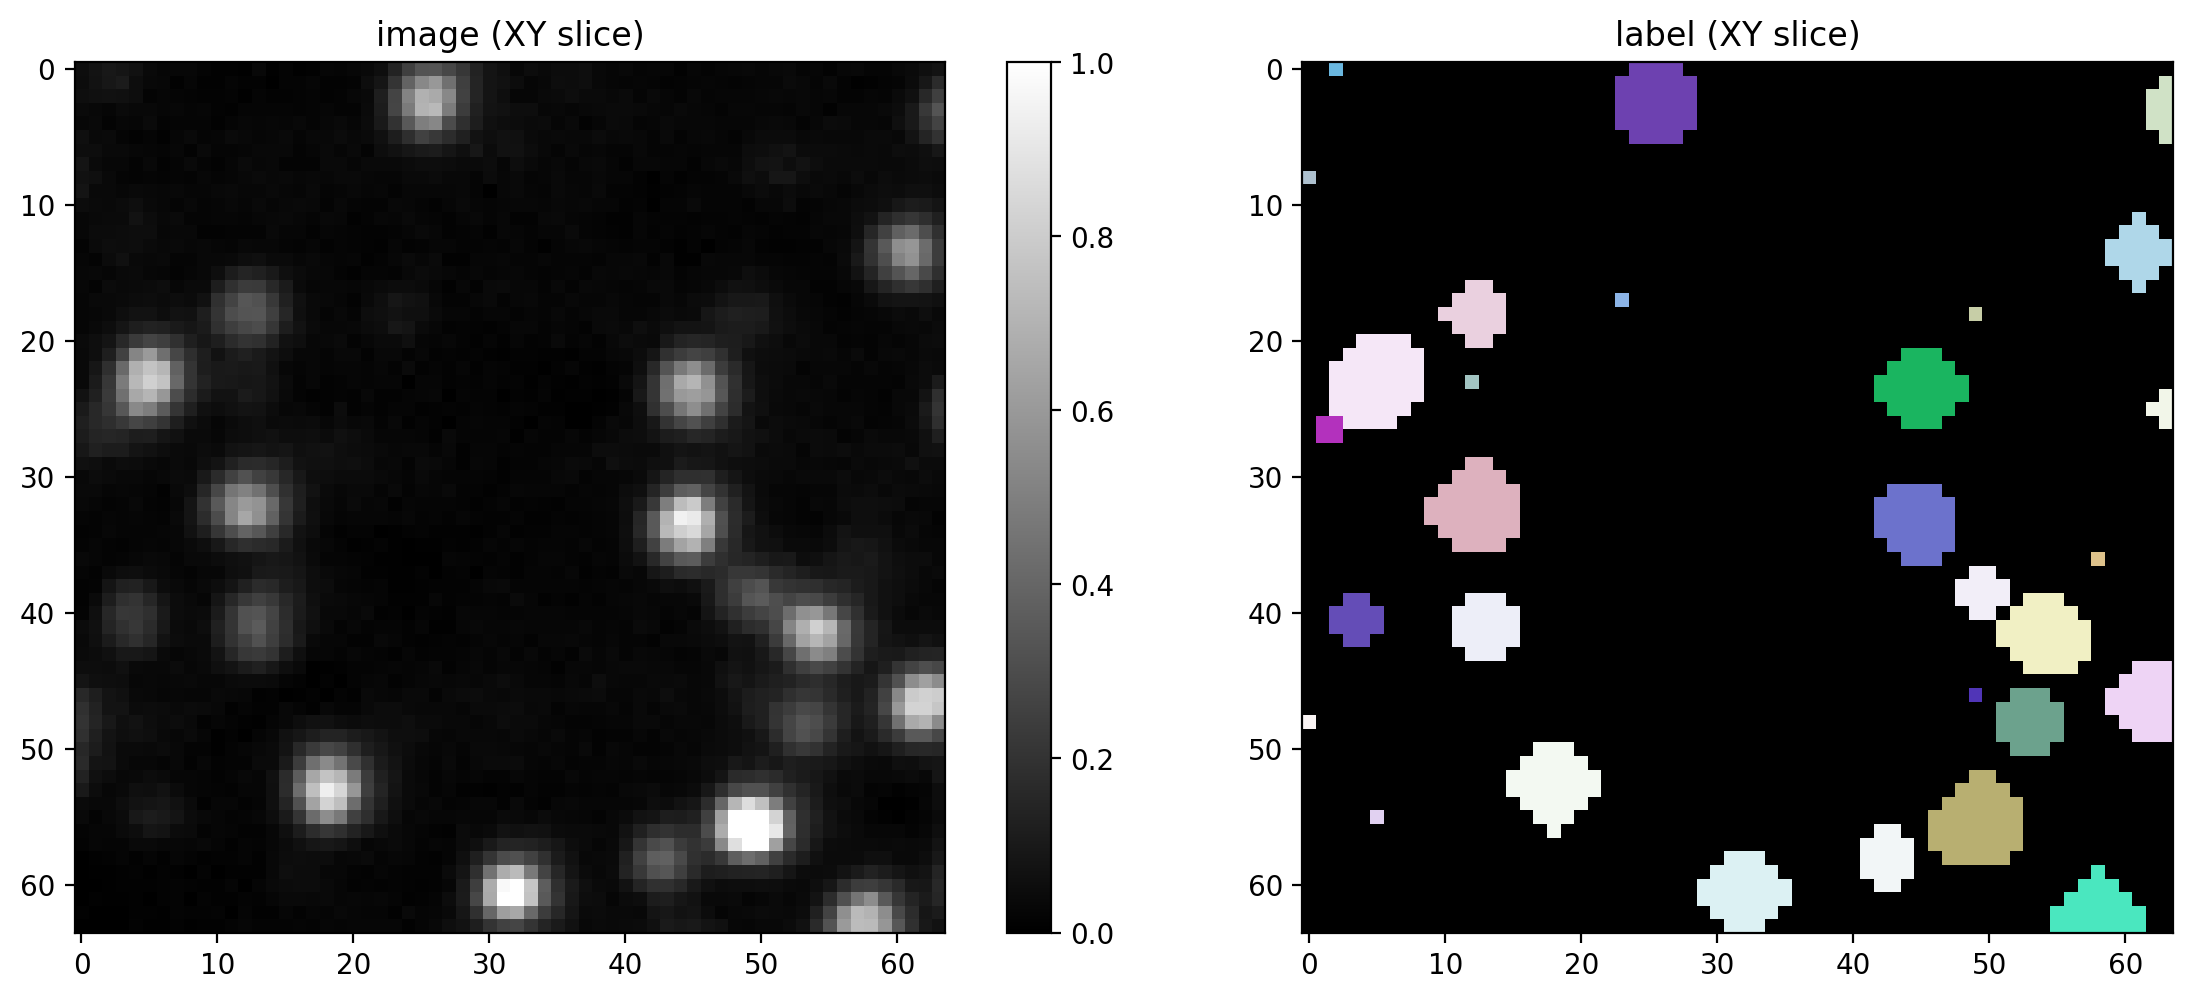

In [5]:
# Function to shoe an XY slice of raw and mask image
def plot_img_label(img, lbl, img_title="image (XY slice)", lbl_title="label (XY slice)", z=None, **kwargs):
    if z is None:
        z = img.shape[0] // 2    
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img[z], cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl[z], cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

i = 2
img, lbl = X[i], Y[i]
img = img if img.ndim==3 else img[...,:3]
plot_img_label(img,lbl)


### Configure and Train Model

In [6]:
# Calculate anisotropy. Should be (2.0, 1.8, 1.8) for SmartSpim data
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (1.0, 1.3571428571428572, 1.3571428571428572)


In [7]:
# function to get total memory for allocation
import subprocess as sp

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values


# Parameterize model
n_rays =96
n_channel = 1
use_gpu = True

# Predict on subsampled grid for increased efficiency and larger field of view
grid = tuple(1 if a > 1.5 else 2 for a in anisotropy)

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

conf = Config3D (
    rays             = rays,
    grid             = grid,
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = n_channel,
    # adjust for your data below (make patch size as large as possible)
    train_patch_size = (16,32,32),
    train_batch_size = 2,
)

# parameterize gpu usage
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    gpu_mem = get_gpu_memory()
    limit_gpu_memory(0.8, total_memory = gpu_mem[0])
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)



In [8]:
# create model and test parameters
model_dir = os.path.join(root, 'models')
model_name = 'stardist_trained_with_' + str(n_rays) + '_rays'
model = StarDist3D(conf, name = model_name, basedir = model_dir)

median_size = calculate_extents(Y, np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

base_model.py (149): output path for model already exists, files may be overwritten: /home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/stardist_training/models/stardist_trained_with_96_rays
2022-12-12 07:11:09.734241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 07:11:11.026890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8816 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5
2022-12-12 07:11:11.027744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 8816 MB memory:  -> devic

Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.468916, nms_thresh=0.5.


2022-12-12 07:11:13.094835: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


1/1 [==============================] - 0s 31ms/step
median object size:      [9.5 7.  7. ]
network field of view :  [46 46 46]


In [9]:
model.train(X_trn, Y_trn, validation_data = (X_val,Y_val), augmenter = None)    

Epoch 1/400
Cause: Unable to locate the source code of <function _gcd_import at 0x7f6016c18430>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7f6016c18430>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7f6016c18430>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - 7s 33ms/step - loss: 0.6851 - prob_loss: 0.2467 - dist_loss: 2.1919 - prob_kld: 0.1948 - dist_relevant_mae: 2.1918 - dist_relevant_mse: 7.6131 - dist_dist_iou_metric: 0.1731 - val_loss: 0.5135 - val_prob_loss: 0.2456 - val_dist_loss: 1.3392 - val_prob_kld: 0.1516 - val_dist_relevant_mae: 1.3390 - val_dist_relevant_mse: 3.0695 - val_dist_dist_iou_metric: 0.3540 - lr: 3.0000e-04
Epoch 2/400
100/100 [==============================] - 2s

### Optimize Thresholds

In [10]:
model.optimize_thresholds(X_val, Y_val)

1/1 [==============================] - 0s 380ms/step


NMS threshold = 0.5:  80%|████▊ | 16/20 [00:04<00:01,  3.30it/s, 0.486 -> 0.457]


Using optimized values: prob_thresh=0.486345, nms_thresh=0.4.
Saving to 'thresholds.json'.


{'prob': 0.4863448633737966, 'nms': 0.4}

### Segmentation Evaluation

In [11]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


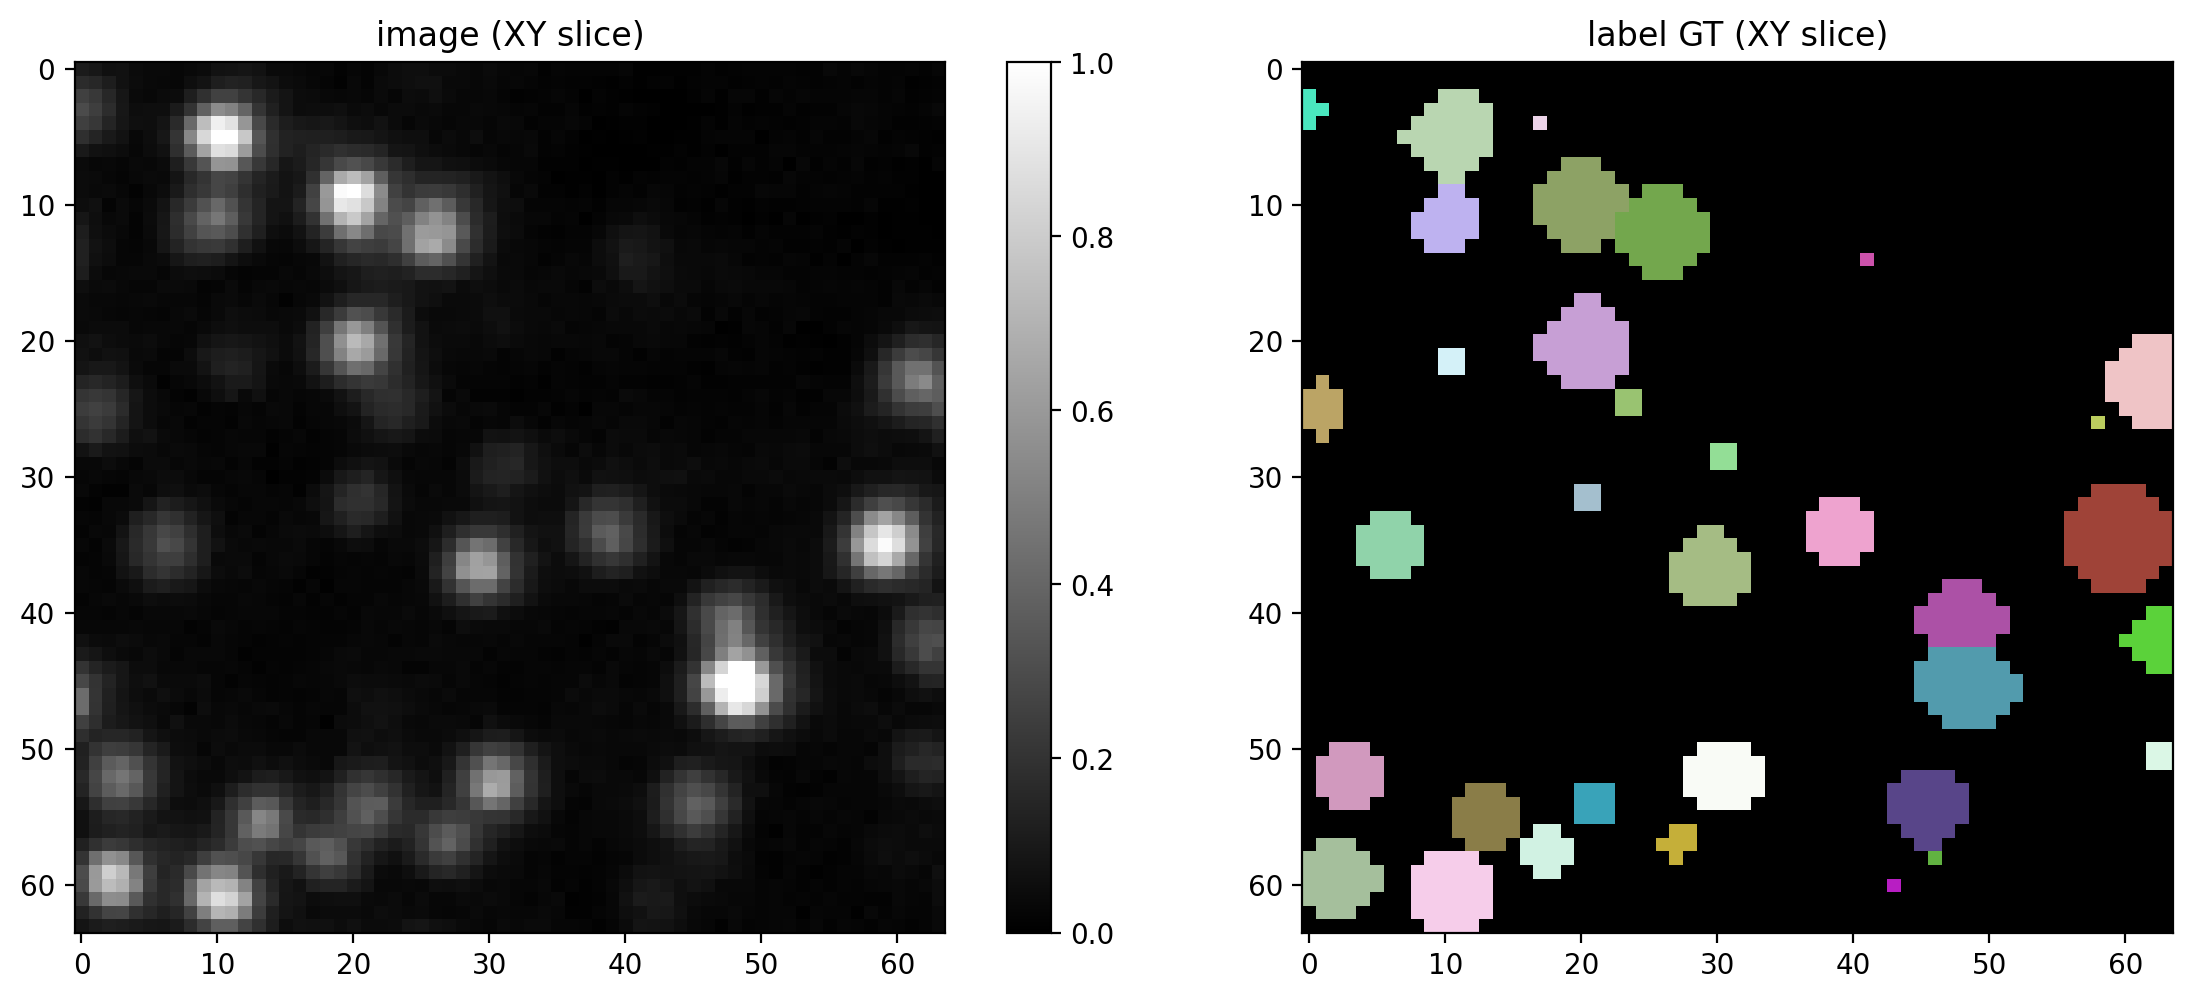

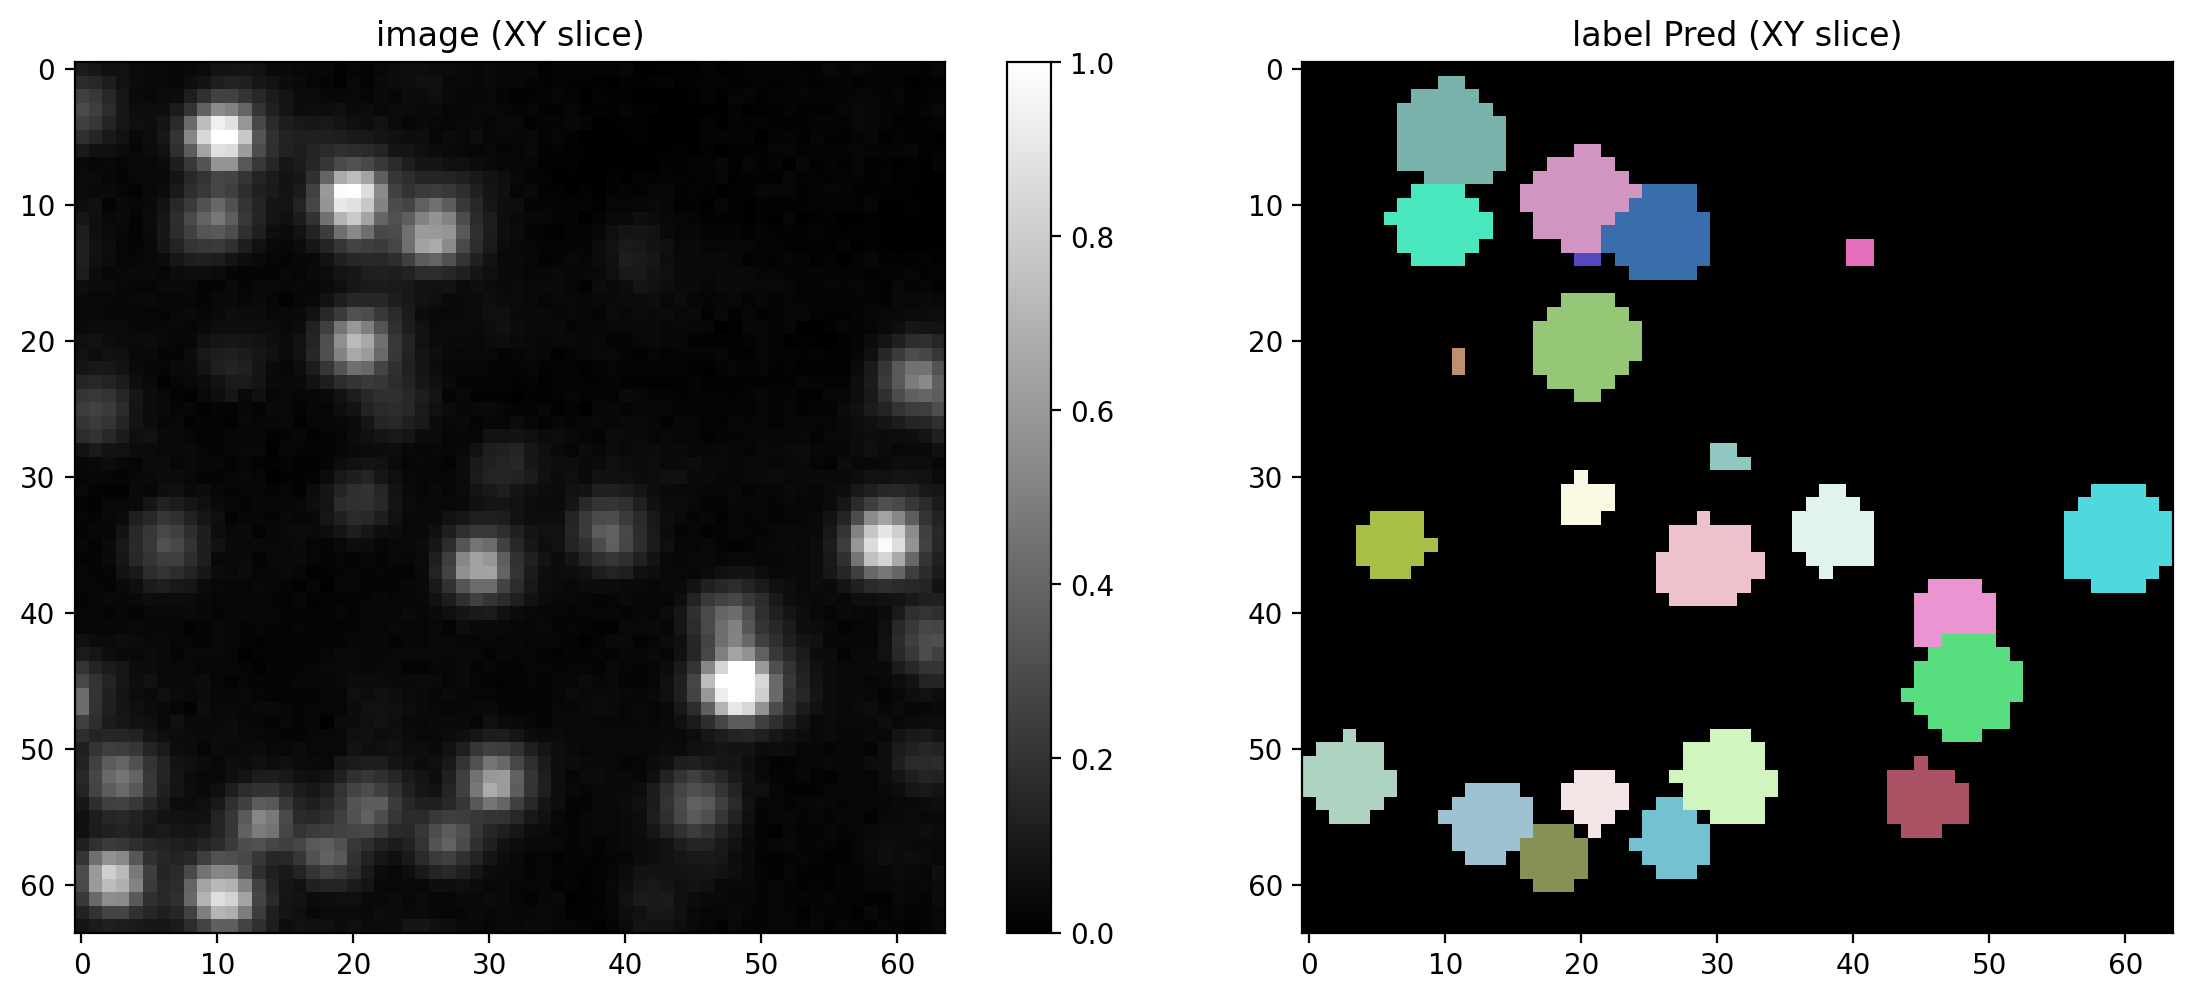

In [12]:
# plot istance of image along with mask and prediction
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT (XY slice)")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred (XY slice)")

In [13]:
# get metrics across range of IOU values
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]


100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 91.29it/s]


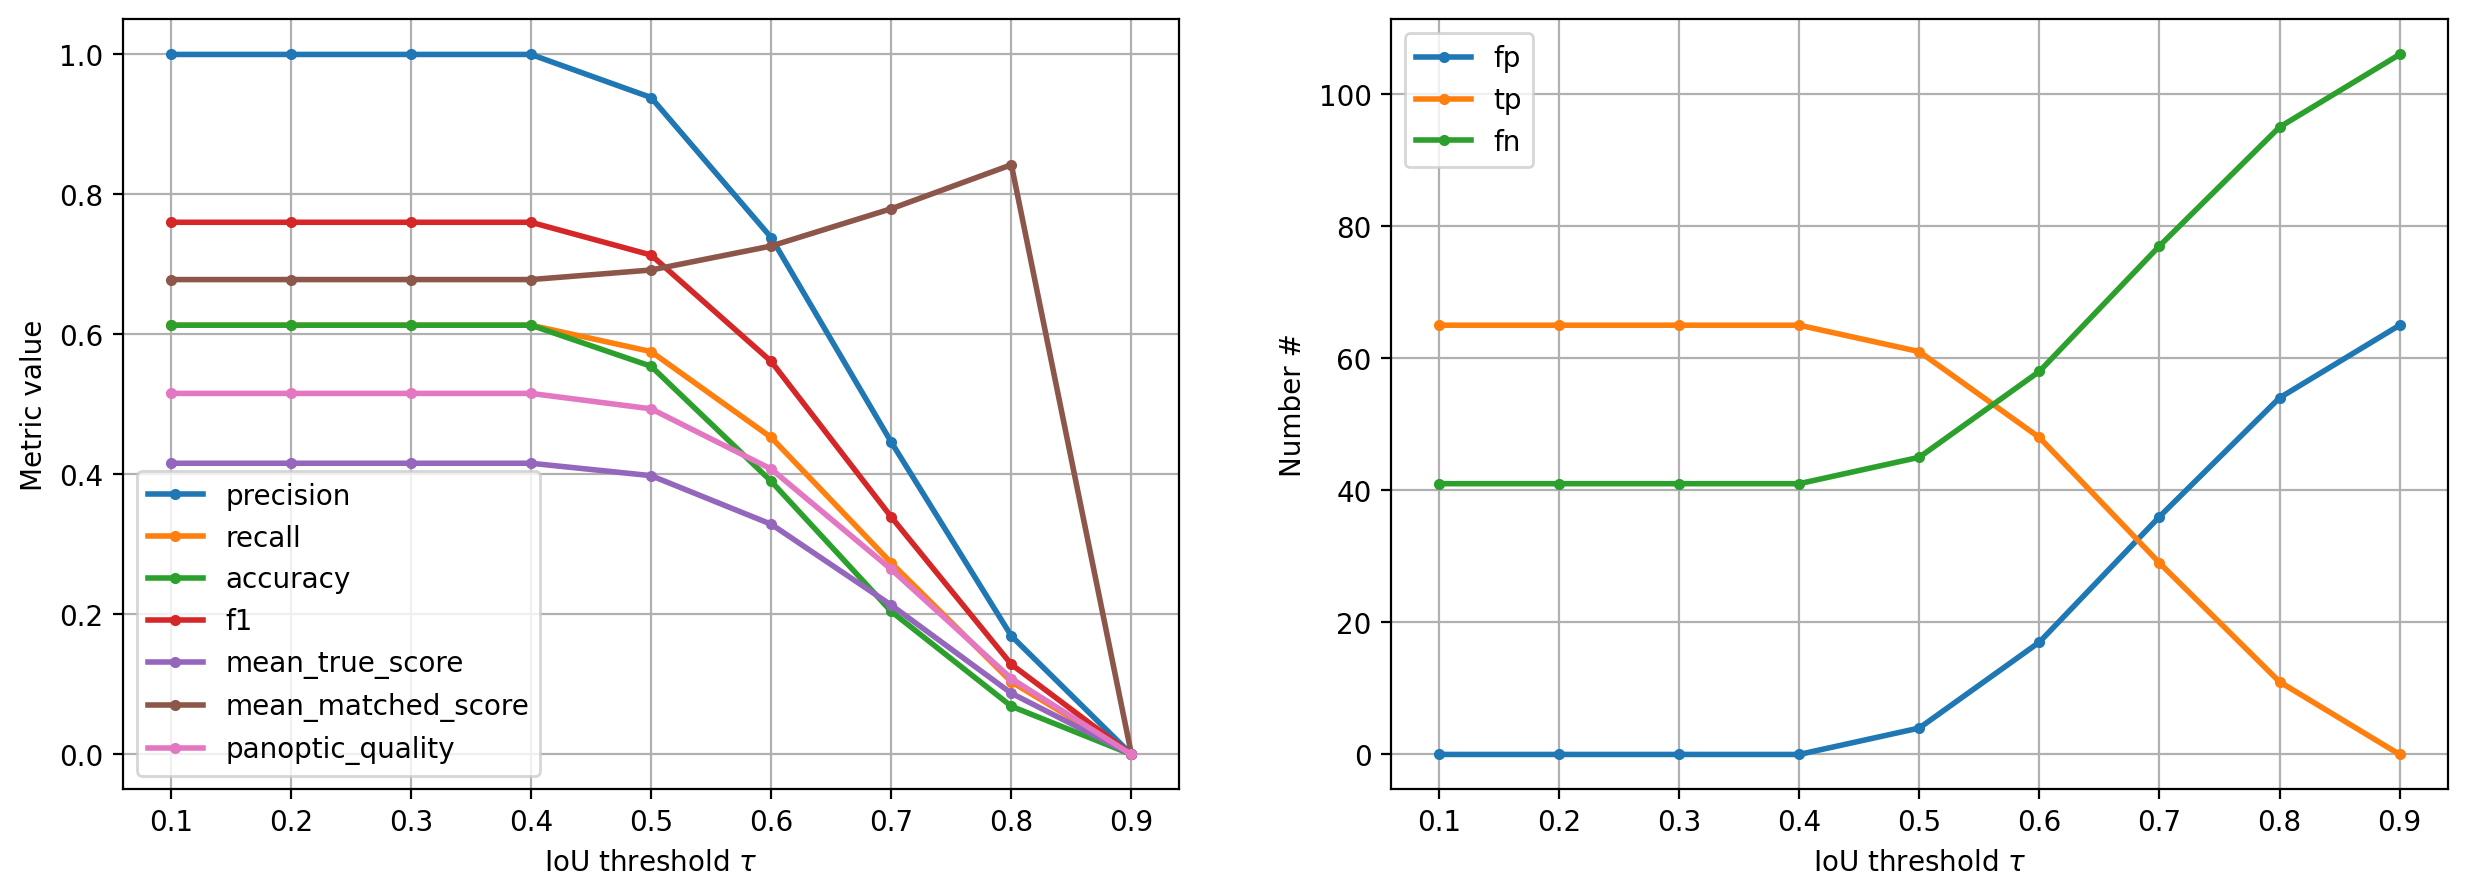

In [14]:
# plot prediction metrics across IOU values
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

### Import Annotated Data

In [5]:
# Get annotated data and image file paths
import re
import os

import utils.preprocess as pp
import utils.evaluate as evaluate

from collections import defaultdict

base_dir = '/home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/images/annotated'
output_root = '/home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/stardist_output'

# create output directory if it doesn't already exist
if not os.path.exists(output_root):
    os.mkdir(output_root)

blocks = defaultdict(dict)

# loop through base directory and collect all data from "block_#" subfolders
for root, dirs, files in os.walk(base_dir):
    if 'block' in root: 
        for file in files:
            try:
                block_num = re.findall('[0-9]', file)[0]
            except:
                continue
            if 'signal' in file:
                blocks[block_num]['signal'] = os.path.join(root, file)
            elif 'background' in file:
                blocks[block_num]['background'] = os.path.join(root, file)
            elif 'detect' in file:
                blocks[block_num]['detect'] = pp.get_locations(os.path.join(root, file))
            else:
                blocks[block_num]['reject'] = pp.get_locations(os.path.join(root, file))

# print info on blocks        
for key in blocks.keys():
    try:
        rejected = len(blocks[key]['reject'])
    except:
        rejected = 0
    print('Pulled annotation data for block {0}: {1} cells and {2} noncells.'.format(str(key), len(blocks[key]['detect']), rejected))

Pulled annotation data for block 4: 2168 cells and 0 noncells.
Pulled annotation data for block 1: 1751 cells and 2 noncells.
Pulled annotation data for block 3: 410 cells and 5 noncells.
Pulled annotation data for block 2: 1641 cells and 2 noncells.


### Import Trained Model

In [16]:
model_dir = '/home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/stardist_training/models'
model_name = 'stardist_trained_with_' + str(n_rays) + '_rays'
model = StarDist3D(None, name = model_name, basedir = model_dir)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486345, nms_thresh=0.4.


### Run Trained Model on Annotated Data

In [17]:
import time
import skimage.io

from skimage.measure import regionprops

# model parameters
chs = ['signal', 'background']
method = 'stardist'
detect_times = defaultdict(int)
axis_norm = (0,1,2)   # normalize channels independently

#preprocessing parameters
bkg_sub = True
estimator = 'SExtractorBackground'
pad = 50

total_time = 0
for key in blocks.keys():
        for ch in chs:
            fname = os.path.basename(blocks[key][ch])[:-4]
            img = skimage.io.imread(blocks[key][ch])
            
            if bkg_sub:
                img = pp.astro_preprocess(img, estimator, pad = pad)
            
            start_detect = time.time()
            # need top normalize. will send warning if you forget
            img_norm = normalize(img,1,99.8,axis=axis_norm)
            
            Y_val_pred = model.predict_instances(img_norm, n_tiles=model._guess_n_tiles(img), show_tile_progress=False)[0]

            # get centroids from masks. see: https://github.com/MouseLand/cellpose/issues/337
            centroids = []
            mask_num = []
            candidates = regionprops(Y_val_pred)
            for c in range(len(candidates)):
                location = [int(x) for x in candidates[c]['centroid']]
                centroids.append(location[::-1])
                mask_num.append(candidates[c]['label'])
        
            if ch == 'signal':
                blocks[key]['pred_detect_' + method] = centroids
                blocks[key]['pred_detect_' + method + '_mask'] = mask_num
            else:
                blocks[key]['pred_reject_' + method] = centroids
                blocks[key]['pred_reject_' + method + '_mask'] = mask_num
            
            # save masks and flows
            output_file = os.path.join(output_root, 'block_' + key + '_mask.tif')
            
            # save masks as tif
            print(Y_val_pred.shape)
            skimage.io.imsave(output_file, Y_val_pred)
            total_time += time.time() - start_detect

detect_times[method] = total_time

1/1 [==============================] - 0s 30ms/step
(150, 350, 350)


678082441.py (53): /home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/stardist_output/block_4_mask.tif is a low contrast image


1/1 [==============================] - 0s 30ms/step
(150, 350, 350)


678082441.py (53): /home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/stardist_output/block_4_mask.tif is a low contrast image


1/1 [==============================] - 0s 29ms/step
(260, 228, 228)


678082441.py (53): /home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/stardist_output/block_1_mask.tif is a low contrast image


1/1 [==============================] - 0s 29ms/step
(260, 228, 228)


678082441.py (53): /home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/stardist_output/block_1_mask.tif is a low contrast image


1/1 [==============================] - 0s 30ms/step
(150, 350, 350)


678082441.py (53): /home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/stardist_output/block_3_mask.tif is a low contrast image


1/1 [==============================] - 0s 29ms/step
(150, 350, 350)


678082441.py (53): /home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/stardist_output/block_3_mask.tif is a low contrast image


1/1 [==============================] - 0s 29ms/step
(260, 228, 228)


678082441.py (53): /home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/stardist_output/block_2_mask.tif is a low contrast image


1/1 [==============================] - 0s 29ms/step
(260, 228, 228)


678082441.py (53): /home/elyse/Documents/GitHub/LS_evaluation_tool/test_data/stardist_output/block_2_mask.tif is a low contrast image


### Save Data

In [18]:
import pickle
pkl_name = '/home/elyse/Documents/stardist_trained_' + str(n_rays) + '_rays_blocks.pickle'

with open(pkl_name, 'wb') as handle:
    pickle.dump(blocks, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
import pickle
n_rays = 32
pkl_name = '/home/elyse/Documents/stardist_trained_' + str(n_rays) + '_rays_blocks.pickle'

with open(pkl_name, 'rb') as handle:
    blocks = pickle.load(handle)
  

### Stardist Outputs and Profile

In [10]:
# get time to run each method
for method in ['stardist']:
    print('Using ' + method + ' method for 2D to 3D')
    for key in blocks.keys():
        print('Classified {0} cells and {1} noncells for annocation block {2}.'.format(len(blocks[key]['pred_detect_' + method]), 
                                                                                       len(blocks[key]['pred_reject_' + method]), 
                                                                                       str(key)))

    print('Detection and Classification via ' + method + ' took {0} seconds.\n'.format(detect_times[method]))

Using stardist method for 2D to 3D
Classified 2053 cells and 3822 noncells for annocation block 4.
Classified 1723 cells and 2964 noncells for annocation block 1.
Classified 398 cells and 1334 noncells for annocation block 3.
Classified 1601 cells and 2930 noncells for annocation block 2.


NameError: name 'detect_times' is not defined

### Plot Performance

Top F1 Scores for stardist detection: 0.9193699446573009


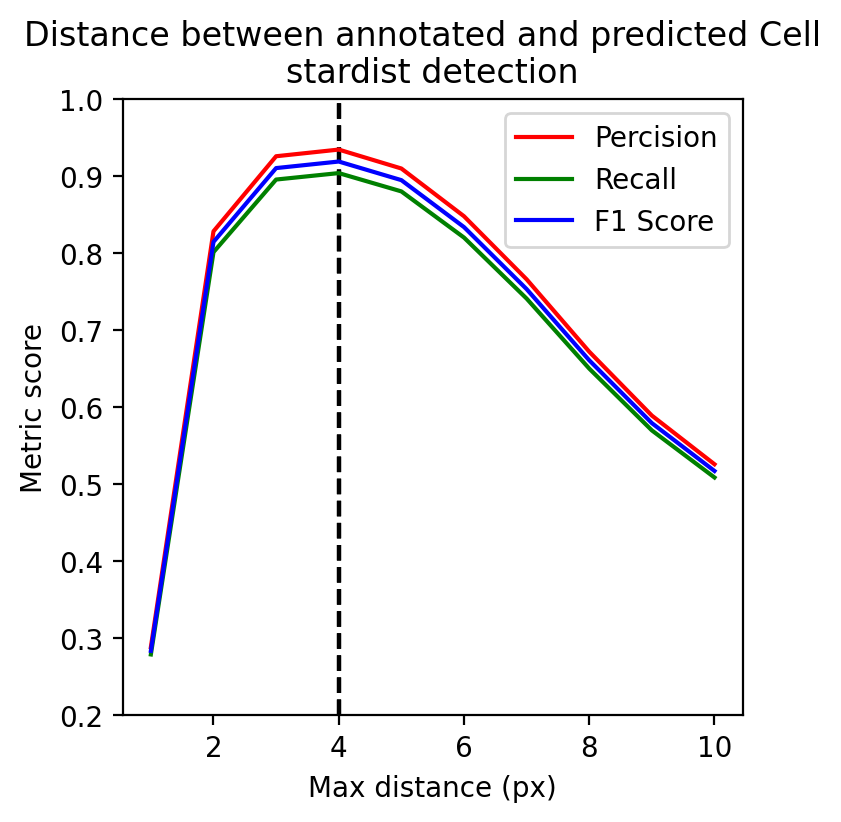

In [12]:
# get metrics on model performance and plot results
import matplotlib.pyplot as plt

%matplotlib inline

methods = ['stardist']
max_dist = 10
trained = False
get_keys = []

performance = evaluate.get_performance(blocks, methods, max_dist, trained, get_keys)
evaluate.plot_performance(performance, methods)

### Classification Matrix Plots

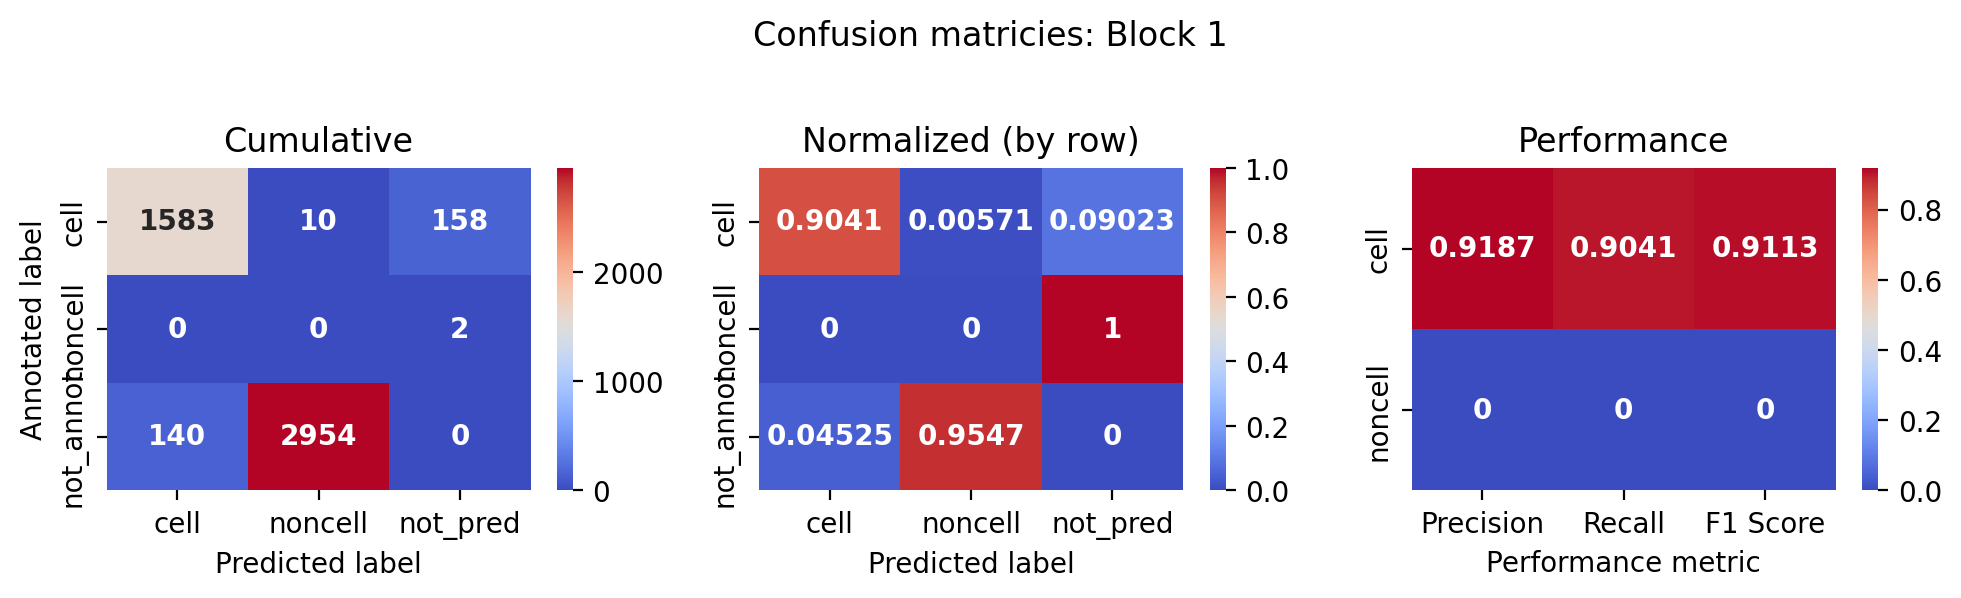

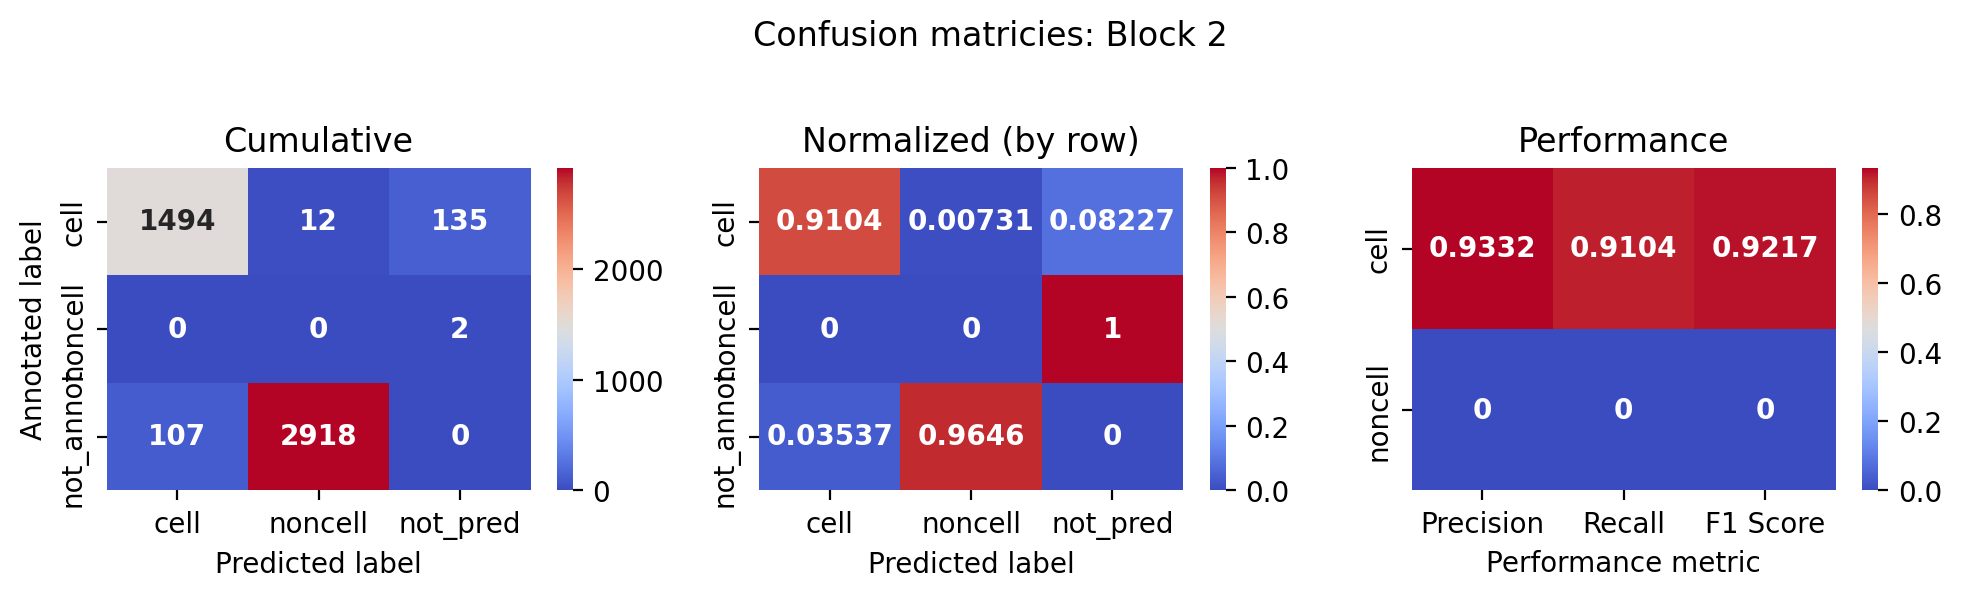

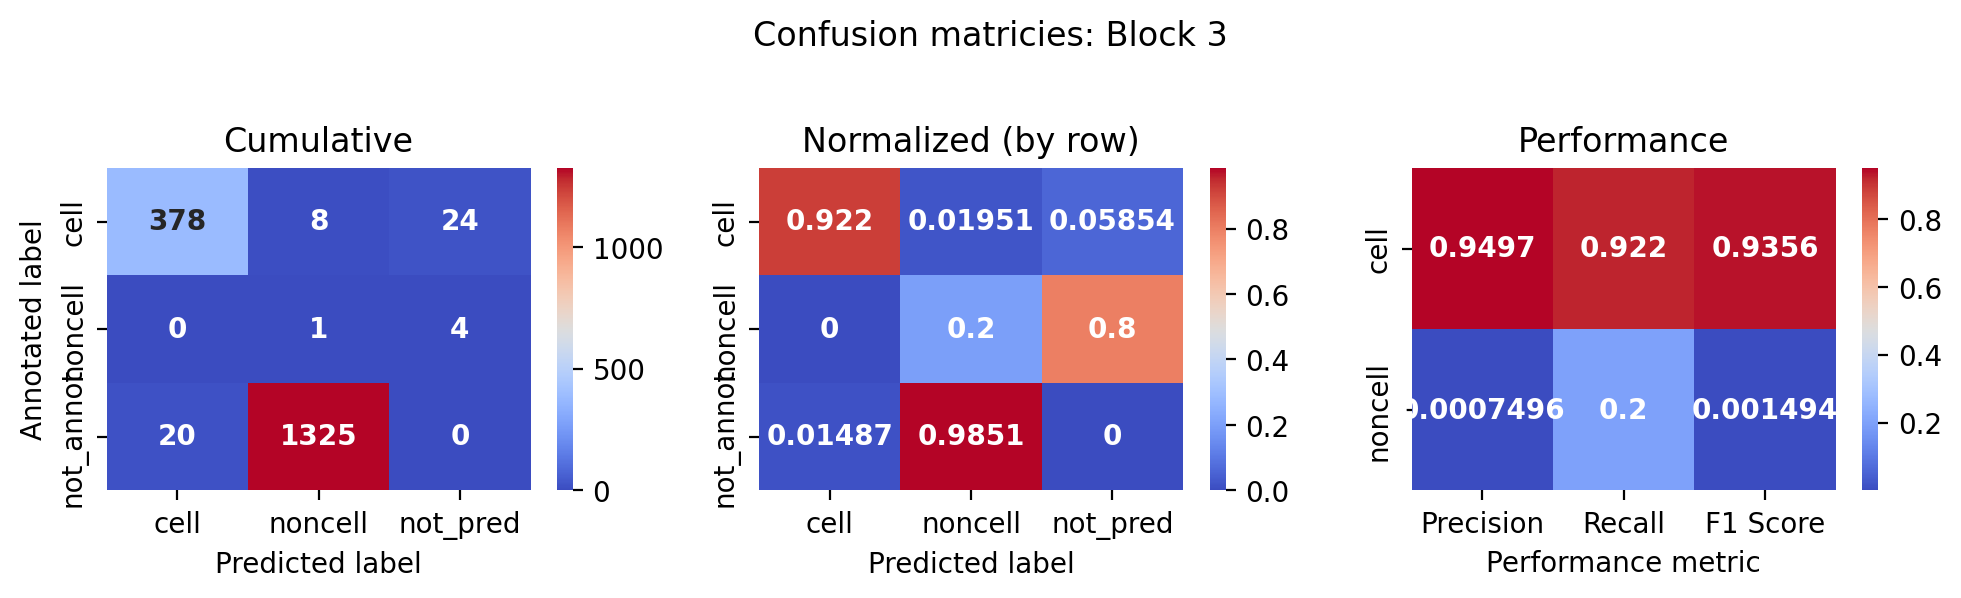

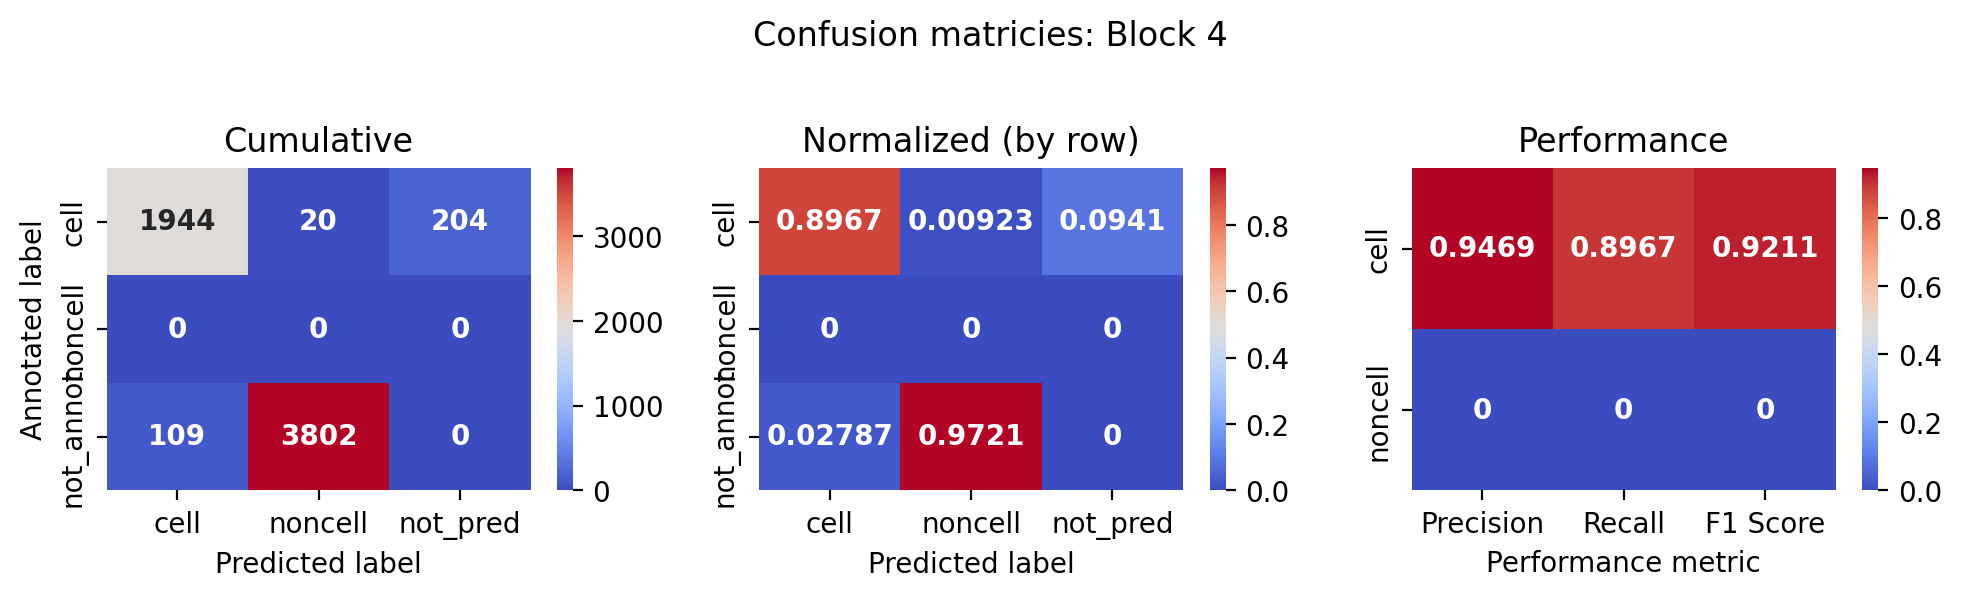

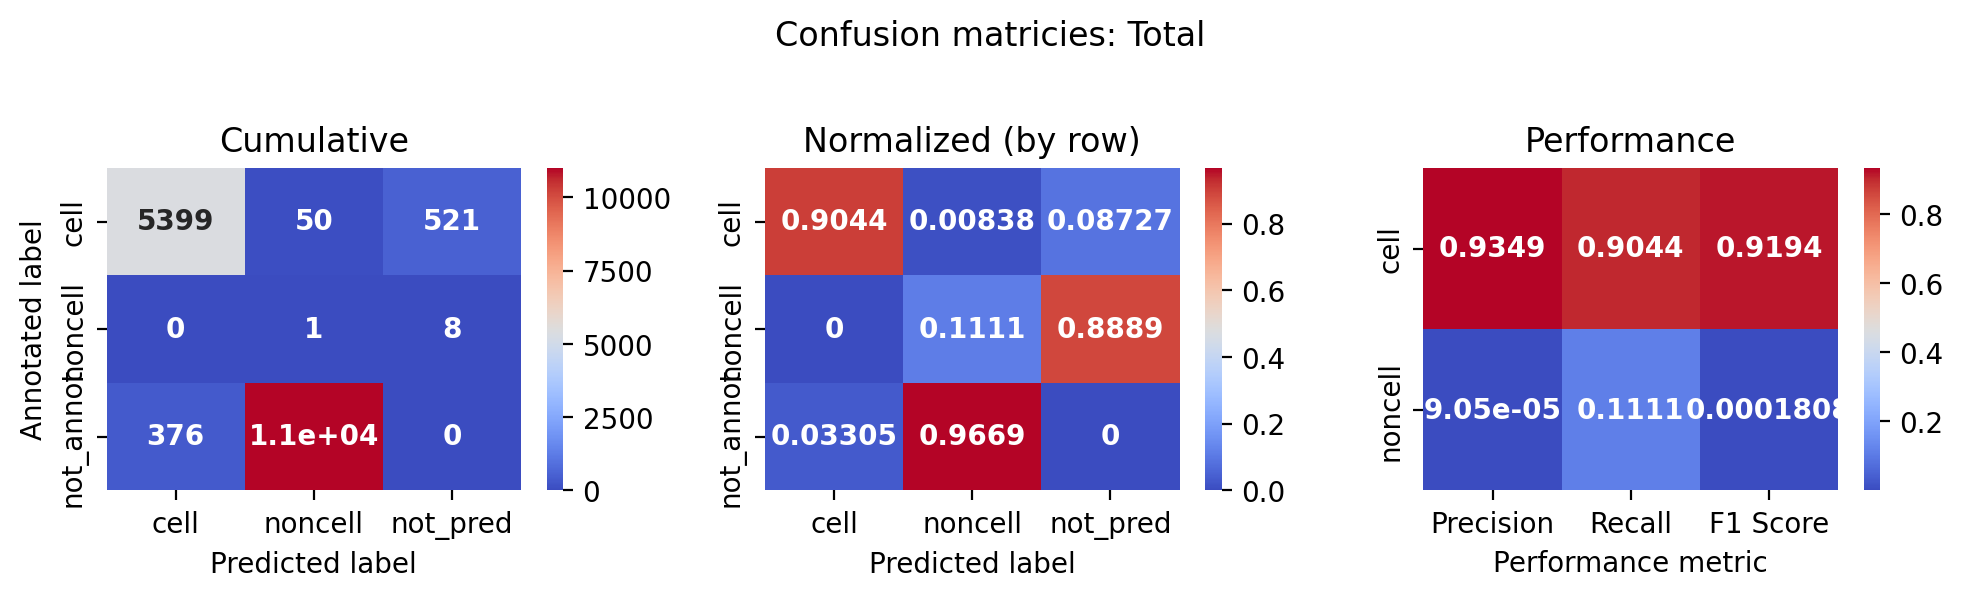

In [13]:
# Classification Matrix Plots
F1_scores = performance[2::3, :-1]
opt_vals = np.unravel_index(np.argmax(F1_scores, axis=None), F1_scores.shape)
metric_df = evaluate.annot_pred_overlap(blocks, opt_vals[0] + 1, methods[opt_vals[1]])

evaluate.plot_cm(metric_df)